In [6]:
%load_ext autoreload
%autoreload 2

from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo", "r2"]

prop_norm_df = create_or_load_property_norm_df()
    
    # create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240416_221922.pt").to(device)
model.eval()
model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240416_225315.pt").to(device)
model_split.eval()
print()

# Optimize properties with MLE

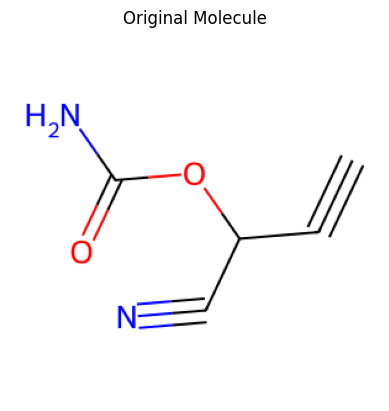

tensor([[-7.9212e+00, -5.3062e-01,  1.2643e+03]], device='cuda:0')


In [6]:
#8, 190, 59, 101
indices = [8, 190, 59, 101]
mol_index = indices[2]

src_mol_graph = val_dataset[mol_index]
src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)
plt.imshow(src_mol_img[0])
plt.title("Original Molecule")
plt.axis("off")
plt.show()
print(model.denormalize_properties(src_mol_graph.y.to(device)))

In [10]:
batch = next(iter(val_loader))
z = model.encode_mean(batch).detach()

z.requires_grad_(True)
optimizer = torch.optim.LBFGS([z], lr=1e-1)

# maximum a posteriori
use_map = True

def closure():
    optimizer.zero_grad()
    y_mu, y_sigma = model.predict_properties(z)
    var = y_sigma * y_sigma
    loss = ((batch[mol_index].y - y_mu) ** 2) # TODO: add var to loss
    if use_map:
        loss += var * (z ** 2).sum(1).unsqueeze(-1)

    loss = loss.mean()
    loss.backward()
    return loss

for i in tqdm(range(500)):
    loss = optimizer.step(closure)
    print(loss)

# Print the final loss value
print(loss.item())

  0%|          | 2/500 [00:00<01:08,  7.24it/s]

tensor(4.7651, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8166, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 4/500 [00:00<01:20,  6.19it/s]

tensor(0.3748, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3594, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 5/500 [00:00<01:25,  5.76it/s]

tensor(0.3564, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/500 [00:01<01:31,  5.38it/s]

tensor(0.3540, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 7/500 [00:01<01:38,  5.03it/s]

tensor(0.3527, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 8/500 [00:01<01:41,  4.86it/s]

tensor(0.3518, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 9/500 [00:01<01:41,  4.86it/s]

tensor(0.3510, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 10/500 [00:01<01:43,  4.76it/s]

tensor(0.3505, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 11/500 [00:02<01:45,  4.65it/s]

tensor(0.3501, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 12/500 [00:02<01:44,  4.68it/s]

tensor(0.3498, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 13/500 [00:02<01:43,  4.71it/s]

tensor(0.3496, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 14/500 [00:02<01:42,  4.73it/s]

tensor(0.3493, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 15/500 [00:02<01:44,  4.63it/s]

tensor(0.3491, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 16/500 [00:03<01:45,  4.57it/s]

tensor(0.3490, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 17/500 [00:03<01:44,  4.63it/s]

tensor(0.3488, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 18/500 [00:03<01:43,  4.67it/s]

tensor(0.3485, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 19/500 [00:03<01:42,  4.71it/s]

tensor(0.3483, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 20/500 [00:04<01:41,  4.74it/s]

tensor(0.3481, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 21/500 [00:04<01:40,  4.77it/s]

tensor(0.3480, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 22/500 [00:04<01:40,  4.77it/s]

tensor(0.3478, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 23/500 [00:04<01:40,  4.73it/s]

tensor(0.3477, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 24/500 [00:04<01:43,  4.61it/s]

tensor(0.3475, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 25/500 [00:05<01:42,  4.63it/s]

tensor(0.3474, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 26/500 [00:05<01:41,  4.68it/s]

tensor(0.3472, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 27/500 [00:05<01:43,  4.59it/s]

tensor(0.3470, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 28/500 [00:05<01:41,  4.67it/s]

tensor(0.3467, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 29/500 [00:05<01:39,  4.72it/s]

tensor(0.3464, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 30/500 [00:06<01:39,  4.74it/s]

tensor(0.3461, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 31/500 [00:06<01:41,  4.61it/s]

tensor(0.3458, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 32/500 [00:06<01:40,  4.64it/s]

tensor(0.3456, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 33/500 [00:06<01:39,  4.68it/s]

tensor(0.3451, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 34/500 [00:07<01:38,  4.71it/s]

tensor(0.3445, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 35/500 [00:07<01:40,  4.62it/s]

tensor(0.3434, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 36/500 [00:07<01:39,  4.67it/s]

tensor(0.3409, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 37/500 [00:07<01:38,  4.72it/s]

tensor(0.3258, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 38/500 [00:07<01:37,  4.75it/s]

tensor(0.2870, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 39/500 [00:08<01:36,  4.77it/s]

tensor(0.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 40/500 [00:08<01:36,  4.79it/s]

tensor(0.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 41/500 [00:08<01:35,  4.80it/s]

tensor(0.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 42/500 [00:08<01:35,  4.79it/s]

tensor(0.2599, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 43/500 [00:08<01:40,  4.54it/s]

tensor(0.2581, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 44/500 [00:09<01:38,  4.63it/s]

tensor(0.2569, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 45/500 [00:09<01:38,  4.64it/s]

tensor(0.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 46/500 [00:09<01:36,  4.70it/s]

tensor(0.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 47/500 [00:09<01:39,  4.57it/s]

tensor(0.2540, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 48/500 [00:10<01:37,  4.64it/s]

tensor(0.2531, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 49/500 [00:10<01:35,  4.70it/s]

tensor(0.2522, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 50/500 [00:10<01:38,  4.58it/s]

tensor(0.2514, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 51/500 [00:10<01:36,  4.65it/s]

tensor(0.2505, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 52/500 [00:10<01:35,  4.69it/s]

tensor(0.2495, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 53/500 [00:11<01:34,  4.71it/s]

tensor(0.2485, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 54/500 [00:11<01:33,  4.76it/s]

tensor(0.2475, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 55/500 [00:11<01:33,  4.77it/s]

tensor(0.2466, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 56/500 [00:11<01:32,  4.78it/s]

tensor(0.2456, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 57/500 [00:11<01:32,  4.80it/s]

tensor(0.2446, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 58/500 [00:12<01:31,  4.81it/s]

tensor(0.2436, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 59/500 [00:12<01:32,  4.76it/s]

tensor(0.2428, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 60/500 [00:12<01:31,  4.79it/s]

tensor(0.2418, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 61/500 [00:12<01:31,  4.80it/s]

tensor(0.2408, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 62/500 [00:12<01:31,  4.79it/s]

tensor(0.2398, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 63/500 [00:13<01:31,  4.77it/s]

tensor(0.2390, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 64/500 [00:13<01:31,  4.78it/s]

tensor(0.2380, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 65/500 [00:13<01:30,  4.78it/s]

tensor(0.2371, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 66/500 [00:13<01:30,  4.79it/s]

tensor(0.2364, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 67/500 [00:14<01:30,  4.79it/s]

tensor(0.2357, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 68/500 [00:14<01:29,  4.80it/s]

tensor(0.2352, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 69/500 [00:14<01:31,  4.71it/s]

tensor(0.2347, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 70/500 [00:14<01:31,  4.69it/s]

tensor(0.2343, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 71/500 [00:14<01:31,  4.70it/s]

tensor(0.2339, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 72/500 [00:15<01:31,  4.69it/s]

tensor(0.2336, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 73/500 [00:15<01:31,  4.66it/s]

tensor(0.2333, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 74/500 [00:15<01:30,  4.70it/s]

tensor(0.2331, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 75/500 [00:15<01:31,  4.64it/s]

tensor(0.2328, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 76/500 [00:15<01:30,  4.70it/s]

tensor(0.2327, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 77/500 [00:16<01:31,  4.63it/s]

tensor(0.2325, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 78/500 [00:16<01:30,  4.68it/s]

tensor(0.2324, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 79/500 [00:16<01:29,  4.73it/s]

tensor(0.2322, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 80/500 [00:16<01:28,  4.75it/s]

tensor(0.2321, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 81/500 [00:16<01:27,  4.78it/s]

tensor(0.2320, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▋        | 82/500 [00:17<01:27,  4.79it/s]

tensor(0.2319, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 83/500 [00:17<01:27,  4.77it/s]

tensor(0.2318, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 84/500 [00:17<01:26,  4.79it/s]

tensor(0.2317, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 85/500 [00:17<01:26,  4.79it/s]

tensor(0.2317, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 86/500 [00:18<01:26,  4.80it/s]

tensor(0.2316, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 87/500 [00:18<01:26,  4.75it/s]

tensor(0.2315, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 88/500 [00:18<01:36,  4.28it/s]

tensor(0.2314, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 89/500 [00:18<01:32,  4.42it/s]

tensor(0.2314, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 90/500 [00:18<01:30,  4.54it/s]

tensor(0.2313, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 91/500 [00:19<01:28,  4.63it/s]

tensor(0.2312, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 92/500 [00:19<01:27,  4.68it/s]

tensor(0.2312, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 93/500 [00:19<01:26,  4.69it/s]

tensor(0.2311, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 94/500 [00:19<01:25,  4.73it/s]

tensor(0.2310, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 95/500 [00:19<01:25,  4.76it/s]

tensor(0.2310, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 96/500 [00:20<01:24,  4.79it/s]

tensor(0.2309, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 97/500 [00:20<01:26,  4.66it/s]

tensor(0.2308, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 98/500 [00:20<01:27,  4.59it/s]

tensor(0.2308, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 99/500 [00:20<01:27,  4.58it/s]

tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 100/500 [00:21<01:26,  4.64it/s]

tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 101/500 [00:21<01:25,  4.68it/s]

tensor(0.2306, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 102/500 [00:21<01:24,  4.72it/s]

tensor(0.2305, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 103/500 [00:21<01:23,  4.73it/s]

tensor(0.2305, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 104/500 [00:21<01:23,  4.75it/s]

tensor(0.2304, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 105/500 [00:22<01:24,  4.69it/s]

tensor(0.2304, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 106/500 [00:22<01:23,  4.74it/s]

tensor(0.2303, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 107/500 [00:22<01:24,  4.67it/s]

tensor(0.2302, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 108/500 [00:22<01:23,  4.72it/s]

tensor(0.2301, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 109/500 [00:22<01:22,  4.75it/s]

tensor(0.2301, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 110/500 [00:23<01:23,  4.67it/s]

tensor(0.2300, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 111/500 [00:23<01:22,  4.71it/s]

tensor(0.2299, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 112/500 [00:23<01:21,  4.75it/s]

tensor(0.2298, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 113/500 [00:23<01:23,  4.64it/s]

tensor(0.2297, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 114/500 [00:24<01:22,  4.66it/s]

tensor(0.2296, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 115/500 [00:24<01:23,  4.61it/s]

tensor(0.2295, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 116/500 [00:24<01:22,  4.66it/s]

tensor(0.2295, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 117/500 [00:24<01:22,  4.66it/s]

tensor(0.2294, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▎       | 118/500 [00:24<01:23,  4.60it/s]

tensor(0.2293, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 119/500 [00:25<01:21,  4.66it/s]

tensor(0.2293, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 120/500 [00:25<01:20,  4.71it/s]

tensor(0.2292, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 121/500 [00:25<01:19,  4.74it/s]

tensor(0.2292, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 122/500 [00:25<01:19,  4.76it/s]

tensor(0.2291, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 123/500 [00:25<01:21,  4.60it/s]

tensor(0.2291, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 124/500 [00:26<01:20,  4.65it/s]

tensor(0.2290, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 125/500 [00:26<01:19,  4.70it/s]

tensor(0.2290, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 126/500 [00:26<01:18,  4.73it/s]

tensor(0.2290, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 127/500 [00:26<01:22,  4.54it/s]

tensor(0.2289, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 128/500 [00:27<01:21,  4.58it/s]

tensor(0.2289, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 129/500 [00:27<01:21,  4.55it/s]

tensor(0.2289, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 130/500 [00:27<01:19,  4.63it/s]

tensor(0.2288, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 131/500 [00:27<01:18,  4.68it/s]

tensor(0.2288, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 132/500 [00:27<01:17,  4.73it/s]

tensor(0.2288, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 133/500 [00:28<01:17,  4.75it/s]

tensor(0.2287, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 134/500 [00:28<01:16,  4.78it/s]

tensor(0.2287, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 135/500 [00:28<01:16,  4.80it/s]

tensor(0.2287, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 136/500 [00:28<01:15,  4.81it/s]

tensor(0.2287, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 137/500 [00:28<01:15,  4.83it/s]

tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 138/500 [00:29<01:14,  4.84it/s]

tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 139/500 [00:29<01:14,  4.84it/s]

tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 140/500 [00:29<01:14,  4.85it/s]

tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 141/500 [00:29<01:13,  4.85it/s]

tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 142/500 [00:29<01:14,  4.80it/s]

tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▊       | 143/500 [00:30<01:14,  4.80it/s]

tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 144/500 [00:30<01:15,  4.70it/s]

tensor(0.2286, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 145/500 [00:30<01:14,  4.74it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 146/500 [00:30<01:14,  4.77it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 147/500 [00:31<01:13,  4.79it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 148/500 [00:31<01:13,  4.81it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 149/500 [00:31<01:13,  4.81it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 150/500 [00:31<01:14,  4.73it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 151/500 [00:31<01:16,  4.58it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 152/500 [00:32<01:15,  4.59it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 153/500 [00:32<01:14,  4.64it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 154/500 [00:32<01:13,  4.68it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 155/500 [00:32<01:14,  4.62it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 156/500 [00:32<01:15,  4.58it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 157/500 [00:33<01:13,  4.64it/s]

tensor(0.2285, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 158/500 [00:33<01:12,  4.69it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 159/500 [00:33<01:12,  4.72it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 160/500 [00:33<01:13,  4.63it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 161/500 [00:34<01:13,  4.59it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 162/500 [00:34<01:12,  4.65it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 163/500 [00:34<01:11,  4.69it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 164/500 [00:34<01:16,  4.37it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 165/500 [00:34<01:15,  4.44it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 166/500 [00:35<01:15,  4.43it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 167/500 [00:35<01:13,  4.54it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▎      | 168/500 [00:35<01:11,  4.61it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 169/500 [00:35<01:10,  4.66it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 170/500 [00:36<01:11,  4.61it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 171/500 [00:36<01:10,  4.66it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 172/500 [00:36<01:09,  4.70it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 173/500 [00:36<01:10,  4.67it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 174/500 [00:36<01:10,  4.65it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 175/500 [00:37<01:09,  4.71it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 176/500 [00:37<01:09,  4.66it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 177/500 [00:37<01:08,  4.71it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 178/500 [00:37<01:07,  4.75it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 179/500 [00:37<01:07,  4.78it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 180/500 [00:38<01:06,  4.80it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 181/500 [00:38<01:06,  4.82it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▋      | 182/500 [00:38<01:07,  4.74it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 183/500 [00:38<01:07,  4.73it/s]

tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 184/500 [00:38<01:07,  4.72it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 185/500 [00:39<01:11,  4.38it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 186/500 [00:39<01:09,  4.50it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 187/500 [00:39<01:08,  4.58it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 188/500 [00:39<01:07,  4.66it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 189/500 [00:40<01:06,  4.70it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 190/500 [00:40<01:05,  4.74it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 191/500 [00:40<01:04,  4.77it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 192/500 [00:40<01:04,  4.78it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▊      | 193/500 [00:40<01:04,  4.78it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 194/500 [00:41<01:07,  4.56it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 195/500 [00:41<01:07,  4.50it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 196/500 [00:41<01:06,  4.60it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 197/500 [00:41<01:05,  4.62it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 198/500 [00:42<01:05,  4.59it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 199/500 [00:42<01:05,  4.57it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 200/500 [00:42<01:04,  4.64it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 201/500 [00:42<01:03,  4.69it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 202/500 [00:42<01:04,  4.65it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 203/500 [00:43<01:03,  4.67it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 204/500 [00:43<01:02,  4.71it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 205/500 [00:43<01:02,  4.73it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 206/500 [00:43<01:01,  4.75it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 207/500 [00:43<01:01,  4.78it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 208/500 [00:44<01:02,  4.69it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 211/500 [00:44<00:44,  6.49it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 213/500 [00:44<00:42,  6.76it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 215/500 [00:45<00:43,  6.53it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 216/500 [00:45<00:46,  6.05it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▎     | 218/500 [00:45<00:41,  6.80it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 219/500 [00:45<00:45,  6.15it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 220/500 [00:45<00:48,  5.78it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 221/500 [00:46<00:50,  5.49it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 224/500 [00:46<00:37,  7.27it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 225/500 [00:46<00:41,  6.61it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 227/500 [00:46<00:38,  7.02it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 228/500 [00:47<00:43,  6.27it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 229/500 [00:47<00:47,  5.73it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 231/500 [00:47<00:45,  5.89it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 233/500 [00:48<00:44,  6.04it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 238/500 [00:48<00:22, 11.55it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 240/500 [00:48<00:26,  9.89it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 242/500 [00:48<00:30,  8.46it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 244/500 [00:49<00:25,  9.86it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 248/500 [00:49<00:29,  8.44it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 250/500 [00:49<00:25,  9.86it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 252/500 [00:50<00:30,  8.13it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 254/500 [00:50<00:31,  7.70it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 255/500 [00:50<00:35,  6.91it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 258/500 [00:50<00:29,  8.11it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 262/500 [00:51<00:25,  9.24it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 264/500 [00:51<00:21, 10.75it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 268/500 [00:51<00:17, 13.60it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 272/500 [00:52<00:19, 11.66it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 277/500 [00:52<00:16, 13.23it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 281/500 [00:52<00:12, 17.22it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 286/500 [00:52<00:12, 17.53it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 290/500 [00:53<00:12, 17.29it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 295/500 [00:53<00:12, 16.22it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 301/500 [00:53<00:13, 15.25it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 308/500 [00:54<00:08, 21.53it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 315/500 [00:54<00:07, 23.78it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▎   | 318/500 [00:54<00:07, 24.26it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 321/500 [00:54<00:09, 18.62it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 328/500 [00:54<00:07, 21.61it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 331/500 [00:55<00:07, 21.13it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 338/500 [00:55<00:07, 23.01it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 341/500 [00:55<00:06, 23.02it/s]

tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2283, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 342/500 [00:55<00:25,  6.14it/s]


KeyboardInterrupt: 

In [5]:
#x = model.decode(z)
writer = create_tensorboard_writer(experiment_name="optimol")
num_valid_mols = 0
for i in range(batch_size):
    #x = val_dataset[i].unsqueeze(0)
    #sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

    #sample_graph = model.output_to_graph(x=x, stochastic=False)

    # check if the generated graph is connected
    #if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
    #    continue
    #src_mol_graph = 
    #src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
    try:
        mol = graph_to_mol(data=val_dataset[i], includes_h=include_hydrogen, validate=True)
    except Exception as e:
        # Molecule is invalid; try to decode again
        continue

    # Molecule is valid
    num_valid_mols += 1
    smiles = Chem.MolToSmiles(mol)
    writer.add_image('Dataset', mol_to_image_tensor(mol=mol), global_step=i, dataformats="NCHW")

print(f"Validity = {num_valid_mols / batch_size}")

Validity = 1.0


# Sample Posterior Subset

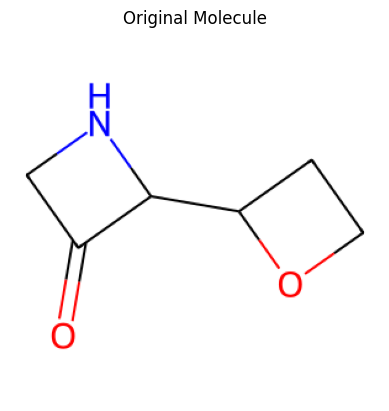

tensor([[-6.5471e+00, -6.2314e-01,  1.1364e+03]], device='cuda:0')


In [83]:
#8, 190, 59, 101
indices = [8, 190, 59, 101]
mol_index = indices[0]

src_mol_graph = val_dataset[mol_index]
src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)
plt.imshow(src_mol_img[0])
plt.title("Original Molecule")
plt.axis("off")
plt.show()
print(model.denormalize_properties(src_mol_graph.y.to(device)))

In [89]:
batch = next(iter(val_loader))
z = model_split.encode_mean(batch).detach()
z = model_split.z_to_property_z(z)

z.requires_grad_(True)
optimizer = torch.optim.LBFGS([z], lr=1e-2)

# maximum a posteriori
use_map = True

def closure():
    optimizer.zero_grad()
    y_mu, y_sigma = model_split.predict_properties(z)
    loss = ((batch[mol_index].y - y_mu) ** 2)
    loss = loss.mean()
    loss.backward()
    return loss

for i in tqdm(range(500)):
    loss = optimizer.step(closure)

# Print the final loss value
print(loss.item())

100%|██████████| 500/500 [00:12<00:00, 38.85it/s]

6.634868210397826e-09


In [91]:
writer = create_tensorboard_writer(experiment_name="optimol")
for sample_index in range(8):
    random_part = torch.randn(256, 112, device=device)  # 128 - 16 = 112
    z_sample = torch.cat((z, random_part), dim=1)

    x = model.decode(z_sample)
    num_valid_mols = 0
    for i in range(batch_size):
        sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

        sample_graph = model.output_to_graph(x=sample_matrices, stochastic=False)

        # check if the generated graph is connected
        if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
            continue

        try:
            mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
        except Exception as e:
            # Molecule is invalid; try to decode again
            continue

        # Molecule is valid
        num_valid_mols += 1
        smiles = Chem.MolToSmiles(mol)
        writer.add_image(f'Generated Optimized Sample {sample_index}', mol_to_image_tensor(mol=mol), global_step=i, dataformats="NCHW")

    print(f"Validity = {num_valid_mols / batch_size}")

Validity = 0.67578125
Validity = 0.74609375
Validity = 0.68359375
Validity = 0.6484375
Validity = 0.73828125
Validity = 0.73046875
Validity = 0.6796875
Validity = 0.69921875
